In this file the fire index matrix will be calculated using the Matrix calculations file, which uses the fire Weather Index.

In [1]:
#import databases
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import netCDF4
from FireWeatherIndex import FWICLASS
import numpy as np
from tqdm import tqdm
from MatrixCalculations import MATRIXCALC

I want to measure time, to know how fast this algorithm is. We have to do a lot of calculations for this part. There are 12 days with 6 indices and a map of $386*280$ pixels. Which makes $72*386*280=7.7*10^6$ calculations

In [2]:
startTime = datetime.now()

Here the NetCDF-datafiles are loaded

In [3]:
#loading files
folder = "Guido-data/"
temp = netCDF4.Dataset(folder + "tg_2024050112-14H.nc", "r")
rhum = netCDF4.Dataset(folder + "hu_2024050112-14H.nc", "r")
wind = netCDF4.Dataset(folder + "fg_2024050112-14H.nc", "r")
prcp = netCDF4.Dataset(folder + "rr_2024050112-dummy.nc", "r")

print(temp.variables)


{'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    standard_name: time
    long_name: Time in hours
    units: hours since 2000-01-01 00:00:00 UTC
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (12,)
filling off, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    standard_name: longitude
    long_name: Longitude values
    units: degrees_E
    axis: X
unlimited dimensions: 
current shape = (386,)
filling off, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    standard_name: latitude
    long_name: Latitude values
    units: degrees_N
    axis: Y
unlimited dimensions: 
current shape = (280,)
filling off, 'air_temperature': <class 'netCDF4._netCDF4.Variable'>
float64 air_temperature(time, latitude, longitude)
    standard_name: air_temperature
    long_name: Surface air temperature
    units: degrees C
    _FillValue: -9999.0
    missing_value: -9999.0
unlimited dimensions: time
curre

Here the latitude and longitude are found. Then a new datafile is created and three dimensions are added: Longitude, latitude and time. The Langitude and longitude are dependent on the values of the files. The time is unlimited.

In [4]:
#Finding dimensions of one of the files: The files are of the same size, here they are found of the air_temperature. The starting files for
#the different starting variables have to be of the same size to start the algorithm.
latitude = temp.variables['air_temperature'].shape[1]
longitude = temp.variables['air_temperature'].shape[2]
#writing files in a netCDF4 file
ffmcfile = netCDF4.Dataset('ffmcfile.nc', mode='w', format='NETCDF4_CLASSIC')

lat_dim = ffmcfile.createDimension('lat', latitude)  # latitude axis
lon_dim = ffmcfile.createDimension('lon', longitude)  # longitude axis
time_dim = ffmcfile.createDimension('time', None) # unlimited axis (can be appended to).

Here the index units are decided. also the units are decided of the indices we are going to create. 

In [5]:
#Attributes
ffmcfile.title = 'ffmc_test'

#Creating variables
lat = ffmcfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ffmcfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ffmcfile.createVariable('time', np.float64, ('time',))
time.units = 'days from 1-5-2024'
time.long_name = 'time'
ffmc_index = ffmcfile.createVariable('ffmc', np.float64,
                                     ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
ffmc_index.units = '1'
isi_index = ffmcfile.createVariable('isi', np.float64, ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
isi_index.units = '1'
dmc_index = ffmcfile.createVariable('dmc', np.float64, ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
dmc_index.units = '1'
dc_index = ffmcfile.createVariable('dc', np.float64, ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
dc_index.units = '1'
bui_index = ffmcfile.createVariable('bui', np.float64, ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
bui_index.units = '1'
fwi_index = ffmcfile.createVariable('fwi', np.float64, ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
fwi_index.units = '1'

Here are the start values put in matrices. In this version it's put in the ffmcfile as day 0. This means that some other indices need dummyvalues.

In [6]:
#starting constant, for ffmc0. 85 means that the whole matrix start at 85 for the ffmc, this is about the value, where
#it has been dry for 2 or 3 days and not too hot.
#Starting values:
ffmc0 = 85.0

#Here we create the FFMC0 matrix, so we started with 85, and from here we calculate further. The base value is also set on 85
#It's easily changed to another value above. The matrices will converge to a close real value after about 3 days.


value = MATRIXCALC(longitude, latitude, ffmc0)
begin_ffmc = value.MAKE_MAT_FFMC0()
begin_dmc = value.MAKE_MAT_DMC0()
    
begin_dc = value.MAKE_MAT_DC0()


ffmc_index[:, :, :] = begin_ffmc.transpose()

#isi_index[0, :, :] = begin

dmc_index[:,:,:]=begin_dmc.transpose()
dc_index[:,:,:]=begin_dc.transpose()
bui_index[0,:,:]=begin_dc.transpose()
fwi_index[0,:,:]=begin_dc.transpose()


Here the Matrices for the FFMC of 1 to 12 May are calculated. There is no rain data, so that's put on 0, if there is, you can put it in. The data of the four indices need to have the same resolutions.

In [7]:
i=0
while i<12:
    FFMC=ffmc_index[i,:,:].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_FFMC(FFMC=FFMC, temp=temperature, rhum=rhumidity, wind=windspeed)
    i+=1
    ffmc_index[:,:,:]=new_slice.transpose()

The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.


Here the Matrices for the ISI of 1 to 12 May are calculated. It's based on the FFMC data of that day and the windspeed. The data of the FFMC and and wind have to be the same resolution. (The FFMC has no rain data, for now)

In [8]:
i=0
while i<12:
    FFMC=ffmc_index[i, :, :].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_ISI(FFMC=FFMC, wind=windspeed)
    i+=1
    isi_index[i, :, :] = new_slice.transpose()

Here the Matrices for the DMC of 1 to 12 May are calculated. It's based on the DMC data of the last day, the rain, humidity and temperature. The data have to be of the same resolution.(Rain data has been put to 0)

In [9]:
i=0
while i<12:
    DMC=dmc_index[i, :, :].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_DMC(DMC=DMC, month=5, wind=windspeed, temp=temperature, rhum=rhumidity)
    i+=1
    dmc_index[i, :, :] = new_slice.transpose()

The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.


Here the Matrices for the DC of 1 to 12 May are calculated. It's based on the DC data of the former day, the temperature and the rain. The data have to be of the same resolution.(Rain data has been put to 0)

In [10]:
i=0
while i<12:
    DC=dc_index[i, :, :].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_DC(DC=DC, month=5, wind=windspeed, temp=temperature, rhum=rhumidity)
    i+=1
    dc_index[i, :, :] = new_slice.transpose()

The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.


Here the Matrices for theBUI of 1 to 12 May are calculated. It's based on the DC and DMC data of the same day. The data have to be of the same resolution.(Rain data has been put to 0)

In [11]:
i=1

while i<12:
    DMC=dmc_index[i, :, :].transpose()
    DC=dc_index[i, :, :].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_BUI(DMC=DMC, DC=DC, wind=windspeed, temp=temperature, rhum=rhumidity)
    bui_index[i, :, :] = new_slice.transpose()
    i+=1


Here the Matrices for the BUI of 1 to 12 May are calculated. It's based on the ISI and BUI data of the same day. The data have to be of the same resolution.(Rain data has been put to 0) In the end the nc-file is closed.

In [12]:
i=1

while i<12:
    ISI=isi_index[i, :, :].transpose()
    BUI=bui_index[i, :, :].transpose()
    temperature=temp['air_temperature'][i, :, :].transpose()
    rhumidity=rhum['relative_humidity'][i, :, :].transpose()
    windspeed=wind['windspeed'][i, :, :].transpose()
    new_slice = value.MAKE_NEXT_MATRIX_FWI(ISI=ISI, BUI=BUI, wind=windspeed, temp=temperature, rhum=rhumidity)
    fwi_index[i, :, :] = new_slice.transpose()
    i+=1
ffmcfile.close()

The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.
The precipitation are set to 0 everywhere, only use this as a test.


Here the file is read and tested, such we can see one of the matrices made above.

(280, 280, 386)


Text(0.5, 1.0, 'fwi 11 mei')

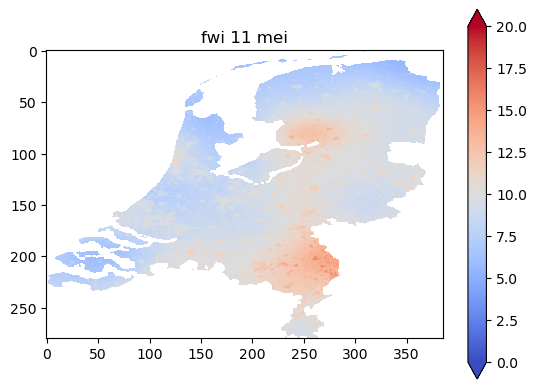

In [13]:
index = netCDF4.Dataset("ffmcfile.nc", "r")
type_of_index = 'fwi'
day=11
print(index.variables[type_of_index].shape)
plt.figure()
    # Here 'useful' values for vmin and vmax for in
#this case ffmc have been chosen. 80 to 90 gives nice pictures, for now
    #80 fvdcto 100/105, would give a more realistic 'view of danger'. For ISI use
plt.imshow(index[type_of_index][day,::-1,:], cmap='coolwarm', vmin=0, vmax=20)
    #making the bar on the right side

plt.colorbar(extend='both')
    #Displaying the title
plt.title(type_of_index + " " + str(day) + " mei")

Time is measured: devide by 12 to get the estimated time for all the indices once. divide by 72 for one of the indices.

In [14]:
print(datetime.now() - startTime)

0:06:55.083728
